<a href="https://colab.research.google.com/github/gagankrmahto/py/blob/master/license_plate_recognition_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D

In [2]:
# Loads the data required for detecting the license plates from cascade classifie https://raw.githubusercontent.com/SarthakV7/AI-based-indian-license-plate-detection/master/indian_license_plate.xml
plate_cascade = cv2.CascadeClassifier('indian_license_plate.xml')
# add the path to 'india_license_plate.xml' file.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!unzip ./data.zip

Streaming output truncated to the last 5000 lines.
 extracting: data/train/class_6/6_234.jpg  
 extracting: data/train/class_6/6_235.jpg  
 extracting: data/train/class_6/6_236.jpg  
 extracting: data/train/class_6/6_237.jpg  
 extracting: data/train/class_6/6_238.jpg  
 extracting: data/train/class_6/6_239.jpg  
 extracting: data/train/class_6/6_24.jpg  
 extracting: data/train/class_6/6_240.jpg  
 extracting: data/train/class_6/6_241.jpg  
 extracting: data/train/class_6/6_242.jpg  
 extracting: data/train/class_6/6_243.jpg  
 extracting: data/train/class_6/6_244.jpg  
 extracting: data/train/class_6/6_245.jpg  
 extracting: data/train/class_6/6_246.jpg  
 extracting: data/train/class_6/6_247.jpg  
 extracting: data/train/class_6/6_248.jpg  
 extracting: data/train/class_6/6_249.jpg  
  inflating: data/train/class_6/6_25.jpg  
 extracting: data/train/class_6/6_250.jpg  
 extracting: data/train/class_6/6_251.jpg  
 extracting: data/train/class_6/6_252.jpg  
 extracting: data/train/cla

In [3]:
def detect_plate(img, text=''): # the function detects and perfors blurring on the number plate.
    plate_img = img.copy()
    roi = img.copy()
    plate_rect = plate_cascade.detectMultiScale(plate_img, scaleFactor = 1.2, minNeighbors = 7) # detects numberplates and returns the coordinates and dimensions of detected license plate's contours.
    for (x,y,w,h) in plate_rect:
        roi_ = roi[y:y+h, x:x+w, :] # extracting the Region of Interest of license plate for blurring.
        plate = roi[y:y+h, x:x+w, :]
        cv2.rectangle(plate_img, (x+2,y), (x+w-3, y+h-5), (51,181,155), 3) # finally representing the detected contours by drawing rectangles around the edges.
    if text!='':
        plate_img = cv2.putText(plate_img, text, (x-w//2,y-h//2), 
                                cv2.FONT_HERSHEY_COMPLEX_SMALL , 0.5, (51,181,155), 1, cv2.LINE_AA)
        
    return plate_img, plate # returning the processed image.

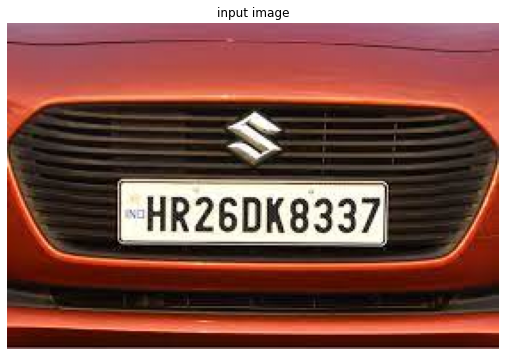

In [23]:
# Testing the above function
def display(img_, title=''):
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(10,6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

img = cv2.imread('car2.jpg')
display(img, 'input image')

In [24]:
# Getting plate prom the processed image
output_img, plate = detect_plate(img,"plate detected")

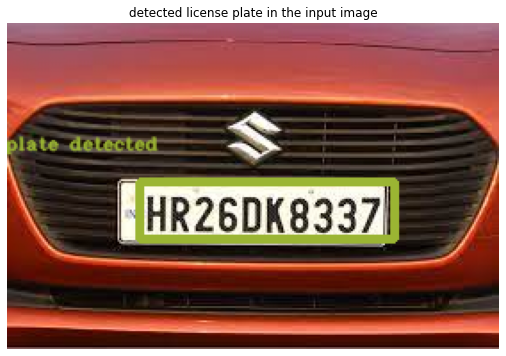

In [25]:
display(output_img, 'detected license plate in the input image')

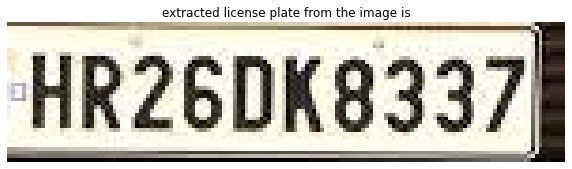

In [26]:
display(plate, 'extracted license plate from the image is')

In [27]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [28]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

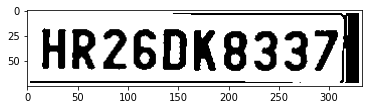

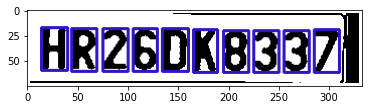

In [29]:
# Let's see the segmented characters
char = segment_characters(plate)

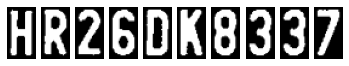

In [30]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

### Model for characters

In [15]:
import tensorflow.keras.backend as K
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data'

train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 7158 images belonging to 36 classes.
Found 215 images belonging to 36 classes.


In [16]:
# Metrics for checking the model performance while training
def f1score(y, y_pred):
  return f1_score(y, tf.math.argmax(y_pred, axis=1), average='micro') 

def custom_f1score(y, y_pred):
  return tf.py_function(f1score, (y, y_pred), tf.double)

In [17]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32,(8,8),input_shape=(28,28,3), activation="relu", padding="same"))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics=[custom_f1score])

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        65568     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        32832     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [18]:
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_custom_f1score') > 0.99):
      self.model.stop_training = True

In [31]:
batch_size = 1
callbacks = [stop_training_callback()]
model.fit_generator(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 80, verbose=1, callbacks=callbacks)
model.save("my_model1.h5")

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/80
7158/7158 [==============================] - 328s 46ms/step - loss: 0.8433 - custom_f1score: 0.7484 - val_loss: 1.2559 - val_custom_f1score: 0.7048
Epoch 2/80
7158/7158 [==============================] - 300s 42ms/step - loss: 0.2785 - custom_f1score: 0.9100 - val_loss: 0.6653 - val_custom_f1score: 0.7849
Epoch 3/80
7158/7158 [==============================] - 301s 42ms/step - loss: 0.1960 - custom_f1score: 0.9359 - val_loss: 0.3357 - val_custom_f1score: 0.8993
Epoch 4/80
7158/7158 [==============================] - 316s 44ms/step - loss: 0.1463 - custom_f1score: 0.9497 - val_loss: 0.1894 - val_custom_f1score: 0.9305
Epoch 5/80
7158/7158 [==============================] - 330s 46ms/step - loss: 0.1167 - custom_f1score: 0.9602 - val_loss: 0.1189 - val_custom_f1score: 0.9653
Epoch 6/80
7158/7158 [==============================] - 300s 42ms/step - loss: 0.1017 - custom_f1score: 0.9652 - val_loss: 0.1044 - val_custom_f1score: 0.9653
Epoch 7/80
7158/7158 [========================

In [21]:
from tensorflow import keras
model = keras.models.load_model('my_model.h5', custom_objects={"custom_f1score": custom_f1score})

In [31]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

HR26DK8337


KeyboardInterrupt: 

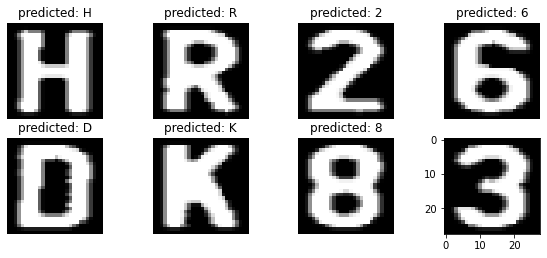

In [32]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

In [ ]:
plate_number = show_results()
output_img, plate = detect_plate(img, plate_number)
display(output_img, 'detected license plate number in the input image')

In [ ]:
!wget https://s3.amazonaws.com/nist-srd/SD19/by_class.zip

In [ ]:
!unzip by_class.zip 

In [ ]:
!wget http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz

In [ ]:
!tar -xvzf EnglishImg.tgz

In [ ]:
!cp /content/English/Img/BadImag/Bmp/Sample014/* /content/data/train/class_D

In [ ]:
j = 11
for i in range(ord('A'),ord("Z")+1):
  print(chr(i), j)
  j=j+1

In [ ]:
j = 36
for i in range(ord('a'),ord("z")+1):
  print(chr(i), j)
  j=j+1

In [ ]:
!cp /content/English/Img/BadImag/Bmp/Sample025/* /content/data/train/class_O

In [ ]:
pip install pytesseract

In [ ]:
import pytesseract
print(pytesseract.image_to_string(plate))